# Craw data

In [47]:
import requests
import pandas as pd


url = "https://archive-api.open-meteo.com/v1/archive"

params = {
    "latitude": 16.0678,
    "longitude": 108.2208,
    "start_date": "2024-01-01",  
    "end_date": "2026-01-15"    ,    
    "hourly": ",".join([
        "temperature_2m",
        "relative_humidity_2m",
        "dew_point_2m",
        "surface_pressure",
        "rain",
        "showers",
        "snow_depth",
        "weather_code",
        "cloud_cover",
        "wind_speed_10m"
    ]),
    "timezone": "auto"
}

# 3. Gọi API
response = requests.get(url, params=params)

if response.status_code == 200:
    data = response.json()
    
    # 4. Xử lý dữ liệu thành bảng (DataFrame)
    hourly_data = data['hourly']
    df = pd.DataFrame(hourly_data)
    
    # 5. Kiểm tra số lượng bản ghi
    print(f"Đã lấy thành công: {len(df)} bản ghi.")
    

    df.to_csv("weather_data_danang.csv", index=False)
    print("Đã lưu file: weather_data_danang.csv")
else:
    print("Lỗi:", response.status_code, response.text)

Đã lấy thành công: 17904 bản ghi.
Đã lưu file: weather_data_danang.csv


In [48]:
df = pd.read_csv("weather_data_danang.csv")
print("shape:", df.shape)
df.info()
df.describe()
df.head()

shape: (17904, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17904 entries, 0 to 17903
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   time                  17904 non-null  object 
 1   temperature_2m        17904 non-null  float64
 2   relative_humidity_2m  17904 non-null  int64  
 3   dew_point_2m          17904 non-null  float64
 4   surface_pressure      17904 non-null  float64
 5   rain                  17904 non-null  float64
 6   showers               17904 non-null  float64
 7   snow_depth            17904 non-null  float64
 8   weather_code          17904 non-null  int64  
 9   cloud_cover           17904 non-null  int64  
 10  wind_speed_10m        17904 non-null  float64
dtypes: float64(7), int64(3), object(1)
memory usage: 1.5+ MB


,time,temperature_2m,relative_humidity_2m,dew_point_2m,surface_pressure,rain,showers,snow_depth,weather_code,cloud_cover,wind_speed_10m
0,2024-01-01T00:00,23.0,89,21.1,1015.0,0.0,0.0,0.0,3,98,3.3
1,2024-01-01T01:00,22.5,92,21.0,1014.7,0.0,0.0,0.0,3,100,1.8
2,2024-01-01T02:00,22.4,92,21.0,1014.0,0.1,0.0,0.0,51,100,2.1
3,2024-01-01T03:00,22.6,90,20.9,1013.6,0.1,0.0,0.0,51,100,2.4
4,2024-01-01T04:00,22.5,90,20.8,1013.4,0.1,0.0,0.0,51,98,3.4


# Visualize data

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
# --- Bước 1: Đọc và Làm sạch dữ liệu ---
df = pd.read_csv('weather_data_danang.csv')
df['time'] = pd.to_datetime(df['time']) 

constant_cols = [col for col in df.columns if df[col].nunique() <= 1]
print(f"-> Đã loại bỏ các cột gây nhiễu (Constant): {constant_cols}")
df_clean = df.drop(columns=constant_cols)

df_clean['month'] = df_clean['time'].dt.month
# xóa các dòng có giá trị thiếu
df_clean = df_clean.dropna()

# xóa cột showers và snow_depth vì có nhiều giá trị 0
# Sử dụng errors='ignore' để tránh lỗi KeyError nếu cột đã bị xóa trước đó (do là constant)
df_clean = df_clean.drop(columns=['showers', 'snow_depth'], errors='ignore')
df_clean.head()

-> Đã loại bỏ các cột gây nhiễu (Constant): ['showers', 'snow_depth']


,time,temperature_2m,relative_humidity_2m,dew_point_2m,surface_pressure,rain,weather_code,cloud_cover,wind_speed_10m,month
0,2024-01-01 00:00:00,23.0,89,21.1,1015.0,0.0,3,98,3.3,1
1,2024-01-01 01:00:00,22.5,92,21.0,1014.7,0.0,3,100,1.8,1
2,2024-01-01 02:00:00,22.4,92,21.0,1014.0,0.1,51,100,2.1,1
3,2024-01-01 03:00:00,22.6,90,20.9,1013.6,0.1,51,100,2.4,1
4,2024-01-01 04:00:00,22.5,90,20.8,1013.4,0.1,51,98,3.4,1


In [50]:

# --- Bước 2: Chọn đặc trưng (Feature Selection) ---
# Tính ma trận tương quan để xem biến nào ảnh hưởng mạnh nhất đến Nhiệt độ
numeric_cols = df_clean.select_dtypes(include=['number']) 
corr_matrix = numeric_cols.corr() 


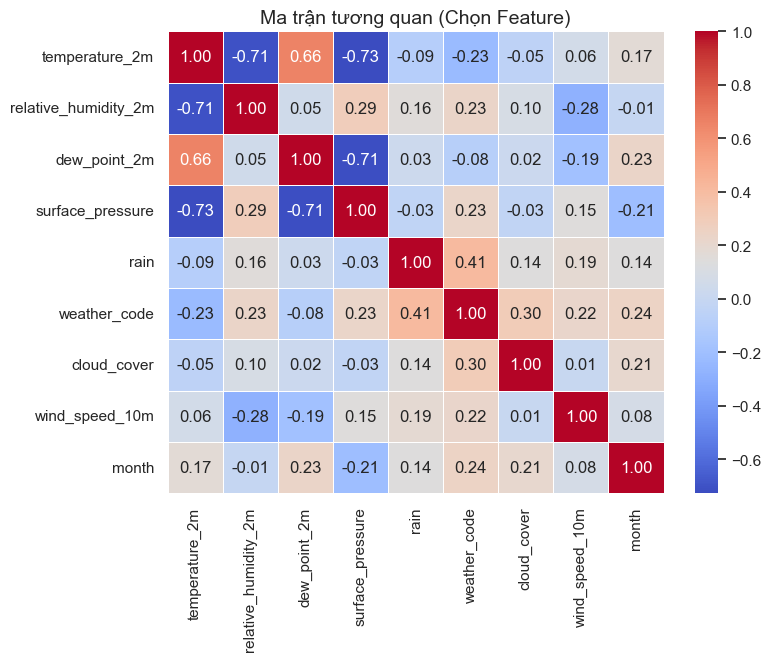

In [51]:
# --- Bước 3: Trực quan hóa (5 Biểu đồ "Must-have") ---
sns.set(style="whitegrid") 

# 1. Heatmap: Để chọn đặc trưng hữu ích
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5) 
plt.title('Ma trận tương quan (Chọn Feature)', fontsize=14)
# xóa weather_code vì nó không phải số liên tục
corr_matrix = corr_matrix.drop(index='weather_code', columns='weather_code')
plt.show()

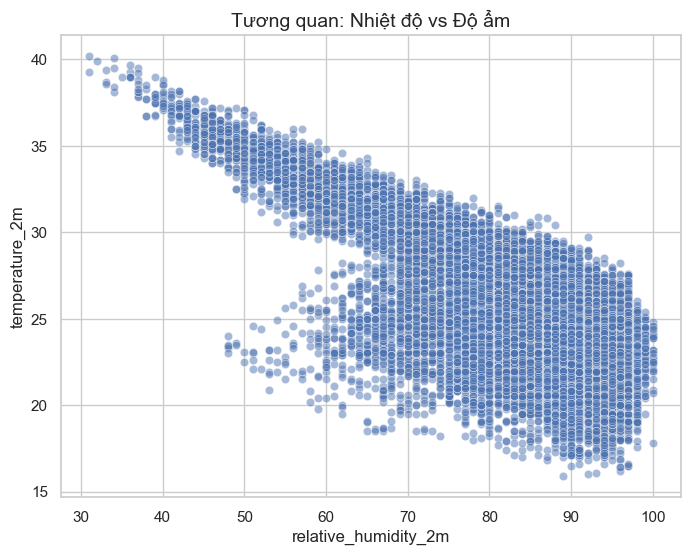

In [52]:
# 5. Scatter Plot: Kiểm tra quan hệ tuyến tính
plt.figure(figsize=(8, 6))
sns.scatterplot(x='relative_humidity_2m', y='temperature_2m', data=df_clean, alpha=0.5)
plt.title('Tương quan: Nhiệt độ vs Độ ẩm', fontsize=14) 
plt.show()

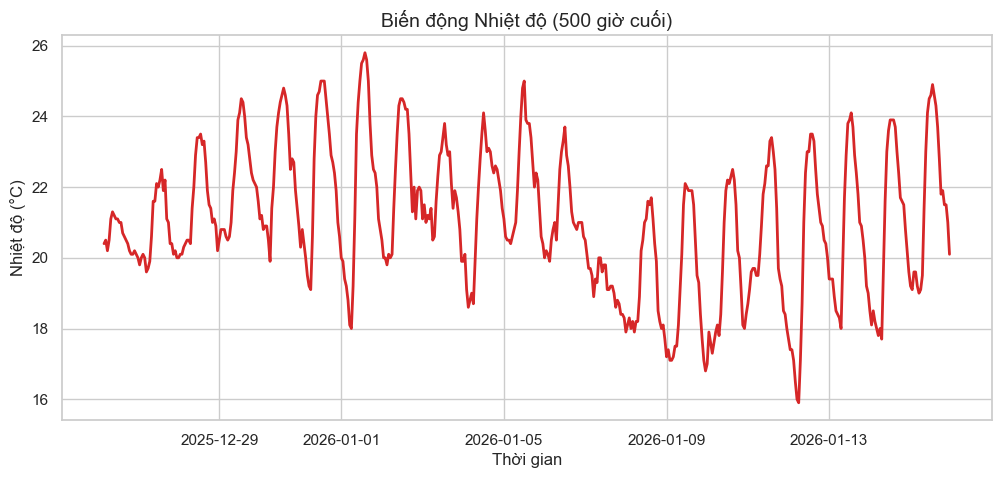

In [53]:
# 2. Line Plot: Xem xu hướng theo thời gian
plt.figure(figsize=(12, 5))
plt.plot(df_clean['time'].tail(500), df_clean['temperature_2m'].tail(500), color='tab:red', linewidth=2)
plt.title('Biến động Nhiệt độ (500 giờ cuối)', fontsize=14)
plt.xlabel('Thời gian')
plt.ylabel('Nhiệt độ (°C)')
plt.show()

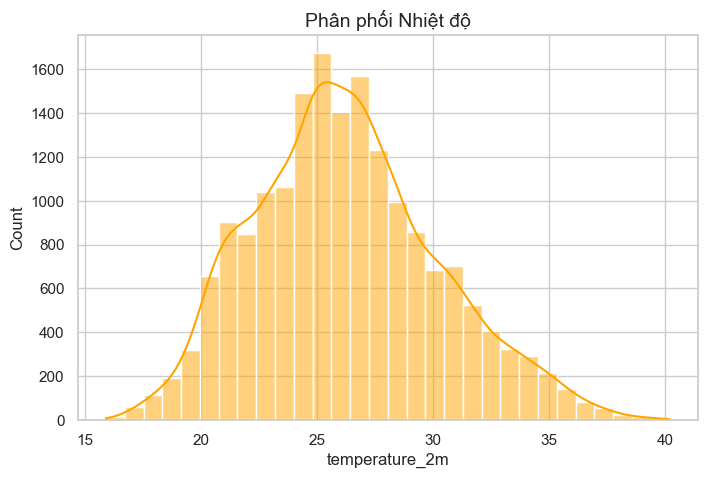

In [54]:
# 3. Histogram: Xem phân phối dữ liệu (Chuẩn hay Lệch?)
plt.figure(figsize=(8, 5))
sns.histplot(df_clean['temperature_2m'], kde=True, bins=30, color='orange')
plt.title('Phân phối Nhiệt độ', fontsize=14) # mục đích là xem phân phối có chuẩn không cụ thể là phân phối Gaussian và xem có lệch không, biểu đồ này có ý nghĩa 
plt.show()

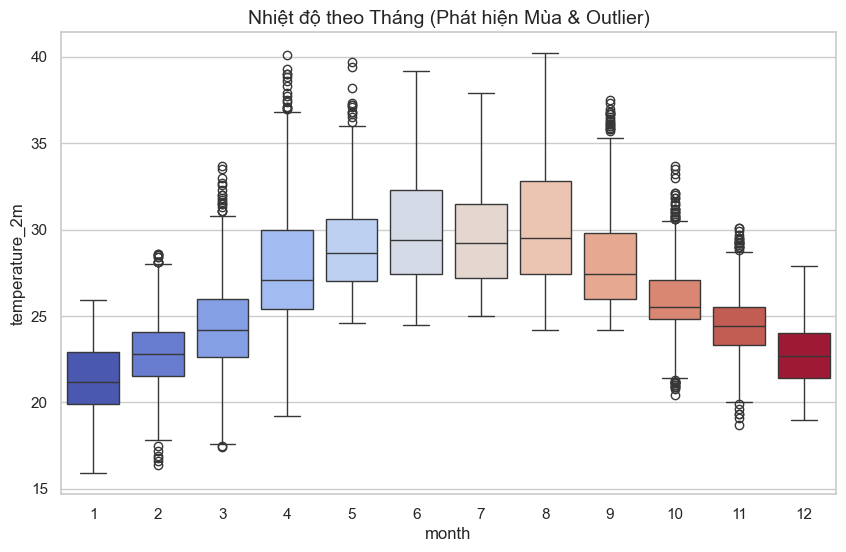

In [55]:
# 4. Boxplot: Phân tích mùa vụ & Outlier
plt.figure(figsize=(10, 6))
sns.boxplot(x='month', y='temperature_2m', data=df_clean, palette="coolwarm", hue='month', legend=False)
plt.title('Nhiệt độ theo Tháng (Phát hiện Mùa & Outlier)', fontsize=14)
plt.show()
# giải thích nội dung biểu đồ boxplot:
# Biểu đồ boxplot hiển thị phân phối nhiệt độ theo từng tháng trong năm. Mỗi hộp (box) thể hiện khoảng giá trị từ Q1 (25%) đến Q3 (75%) của nhiệt độ, với đường nằm giữa hộp là giá trị trung vị (median). Râu (whiskers) kéo dài từ hộp biểu thị phạm vi dữ liệu, trong khi các điểm nằm ngoài râu được coi là outlier (giá trị ngoại lai). Màu sắc khác nhau cho mỗi tháng giúp dễ dàng phân biệt và so sánh sự biến động nhiệt độ giữa các tháng, từ đó có thể nhận biết các mùa trong năm và xác định các giá trị bất thường trong dữ liệu nhiệt độ.

In [56]:
# Huấn luyện mô hình phân loại thời tiết sử dụng các đặc trưng đã chọn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np
# Chọn đặc trưng và nhãn
features = ['relative_humidity_2m', 'dew_point_2m', 'surface_pressure', 'wind_speed_10m']
X = df_clean[features]
y = df_clean['weather_code'] 
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Huấn luyện mô hình Random Forest
# Tạo mô hình
# model = RandomForestClassifier(n_estimators=100, random_state=42) --- IGNORE ---
model = RandomForestClassifier(n_estimators=100, random_state=42)
# Huấn luyện mô hình
# model.fit(X_train, y_train) --- IGNORE ---
model.fit(X_train, y_train)
# Đánh giá mô hình
# accuracy = model.score(X_test, y_test) --- IGNORE ---
accuracy = model.score(X_test, y_test)
print(f"Độ chính xác mô hình: {accuracy*100:.2f}%") 



Độ chính xác mô hình: 46.44%
